In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# set to be lower priority
#os.nice(1) 

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
from joblib import Parallel, delayed

In [5]:
from cdcp.spiketrain_analysis.spiketrain_utils import (
    bin_interp_points,
)

In [6]:
from datetime import datetime

In [7]:
from cdcp.spiketrain_analysis.spiketrain_utils import (
    get_spike_train_vector
)

In [8]:
from cdcp.spiketrain_analysis.unit_stats.cued_similarity_and_spikevector_differences import (
    compute_cued_average_sm_rv_differences
)

In [9]:
DATA_DIR

PosixPath('/n/groups/datta/tim_sainburg/projects/CDCP_paper/data')

In [10]:
!ls -lht /n/groups/datta/tim_sainburg/projects/CDCP_paper/data/population_analyses_with_passive

total 3.4G
-rw-r--r-- 1 tis697 NEUROBIO_DattaLab  8.0G Dec 14 15:51 B1597_spike_array.dat
-rw-r--r-- 1 tis697 NEUROBIO_DattaLab   19G Dec 14 15:02 B1593_spike_array.dat
-rw-r--r-- 1 tis697 NEUROBIO_DattaLab   19G Dec 14 15:00 B1593_spike_array.npy
-rw-r--r-- 1 tis697 NEUROBIO_DattaLab   63M Dec 14 12:58 B1244.pickle
-rw-r--r-- 1 tis697 NEUROBIO_DattaLab   66K Dec 14 12:58 B1244_units_present.npy
-rw-r--r-- 1 tis697 NEUROBIO_DattaLab   20M Dec 14 12:58 B1244_spike_array.npy
-rw-r--r-- 1 tis697 NEUROBIO_DattaLab  220M Dec 14 12:57 B1170.pickle
-rw-r--r-- 1 tis697 NEUROBIO_DattaLab  896K Dec 14 12:57 B1170_units_present.npy
-rw-r--r-- 1 tis697 NEUROBIO_DattaLab 1021M Dec 14 12:57 B1170_spike_array.npy
-rw-r--r-- 1 tis697 NEUROBIO_DattaLab  533M Dec 14 12:52 B1432.pickle
-rw-r--r-- 1 tis697 NEUROBIO_DattaLab  1.5M Dec 14 12:51 B1432_units_present.npy
-rw-r--r-- 1 tis697 NEUROBIO_DattaLab  3.5G Dec 14 12:51 B1432_spike_array.npy
-rw-r--r-- 1 tis697 NEUROBIO_DattaLab   18M Dec 14 12:41 B1426

In [11]:
# "2021-10-07_16-05-58_796914" '2021-10-06_13-30-08_899062' '2021-10-01_17-02-56_744915' 
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [12]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    ##('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    #('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    #('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    #('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    #('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]

In [13]:
min_playbacks = 1000

In [14]:
import pandas as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
from scipy.ndimage import gaussian_filter1d

from sklearn.metrics.pairwise import (
    cosine_similarity,
    euclidean_distances,
    manhattan_distances,
)

In [15]:
def get_unit_spike_trains(
    unit_recording_ids,
    spikesorting_folder,
    sorter,
    unit,
    bird,
    save_folder="trial_aligned_spikes",
):
    trial_aligned_spikes_list = []
    for unit, recording_id in tqdm(
        unit_recording_ids, desc="unit spike trains", leave=False, disable=True
    ):
        trial_aligned_spikes_loc = (
            DATA_DIR
            / "spikesorting"
            / save_folder
            / bird
            / recording_id
            / "{}.pickle.zip".format(unit)
        )
        if trial_aligned_spikes_loc.exists():
            trial_aligned_spikes = pd.read_pickle(trial_aligned_spikes_loc)
            trial_aligned_spikes["recording_id"] = recording_id

            trial_aligned_spikes["stim"] = [
                i[:-4] if i[-4:].lower() == ".wav" else i
                for i in trial_aligned_spikes.stim.values
            ]

            mask = [
                (i.split("_")[-1].isnumeric() and len(i.split("_")[-1]) == 3)
                for i in trial_aligned_spikes.stim.values
            ]

            # get cue info
            trial_aligned_spikes["cue"] = [
                i.split("_")[0] if mask else np.nan
                for i, m in zip(trial_aligned_spikes.stim.values, mask)
            ]
            trial_aligned_spikes["interp"] = [
                i.split("_")[1] if mask else np.nan
                for i, m in zip(trial_aligned_spikes.stim.values, mask)
            ]

            # for i, m in zip(trial_aligned_spikes.stim.values, mask):
            #    if m:
            #        int(i.split("_")[2])
            trial_aligned_spikes["interp_point"] = [
                np.nan if m == False else int(i.split("_")[2])
                for i, m in zip(trial_aligned_spikes.stim.values, mask)
            ]
            trial_aligned_spikes_list.append(trial_aligned_spikes)
        else:
            0
            # print("{} does not have trial aligned spikes yet".format(recording_id))
            # print("\t", trial_aligned_spikes_loc)
    if len(trial_aligned_spikes_list) < 1:
        #breakme
        return None
    else:
        return pd.concat(trial_aligned_spikes_list)

In [16]:
def zscore(x):
    return (x - np.mean(x)) / np.std(x)

def clip(x, _min = -4, _max = 4):
    x[x<_min] = _min
    x[x>_max] = _max
    return x

In [17]:
def get_spike_vector(spike_times, time_min = 0, time_max = 1, n_parts = 5):
    return np.histogram(spike_times, bins = np.linspace(time_min, time_max,  n_parts+1))[0]

def get_n_spikes(
    unit_to_analyze,
    spikesorting_folder,
    statistics_timestamp,
    bird,
    n_interp_point_bins = 16,
    recompute=False,
    parallel=True,
    flip_bins=True,
    n_time_bins=100,
    gaussian_sigma_ms=25,
    save=True,
    plot=False,
):
    # load spike trains
    trial_aligned_spikes = get_unit_spike_trains(
        unit_to_analyze.sort_units,
        spikesorting_folder,
        sorter,
        unit_to_analyze,
        bird=bird,
        save_folder="trial_aligned_spikes_padding_100ms",
    )
    if trial_aligned_spikes is None:
        # because there are not enough spikes for this unit to be worth it
        return

    # ensure interp point is an integer
    trial_aligned_spikes["interp_point_binned"] = bin_interp_points(
        trial_aligned_spikes["interp_point"].values.astype(int),
        n_interp_point_bins,
        flip_bins=flip_bins,
    )
    
    # subset relevant trials
    #trial_aligned_spikes = trial_aligned_spikes[trial_aligned_spikes.passive == False]
    #trial_aligned_spikes = trial_aligned_spikes[
    #    (np.isin(trial_aligned_spikes.cue, ("NC", "CN")) == False)
    #]

    if len(trial_aligned_spikes) < 100:
        return

    trial_aligned_spikes["n_spikes_z"] = clip(zscore(trial_aligned_spikes.n_spikes.values), -4, 4)
    
    n_parts = 20
    spike_times = np.zeros((len(trial_aligned_spikes), n_parts))
    for rowi, (idx, row) in enumerate(trial_aligned_spikes.iterrows()):
        if row.cue == 'NC':
            spike_times[rowi] = get_spike_vector(row.spike_times, time_min = 0, time_max = 1, n_parts = n_parts)
        else:
            spike_times[rowi] = get_spike_vector(row.spike_times, time_min = 1, time_max = 2, n_parts = n_parts)
    # zscore
    spike_times = clip(zscore(spike_times))
    trial_aligned_spikes['spike_vector'] = list(spike_times)
    
    return trial_aligned_spikes[["trial_id", "cue", "interp", "interp_point", "interp_point_binned", "n_spikes_z", "spike_vector"]]

In [18]:
categorical_units_df = pd.read_pickle(DATA_DIR / 'categorical_unit_01_23_22.pickle')
categorical_units_df= categorical_units_df[categorical_units_df.categorical_unit == True]

In [19]:
import tempfile
import shutil

  0%|          | 0/9 [00:00<?, ?it/s]

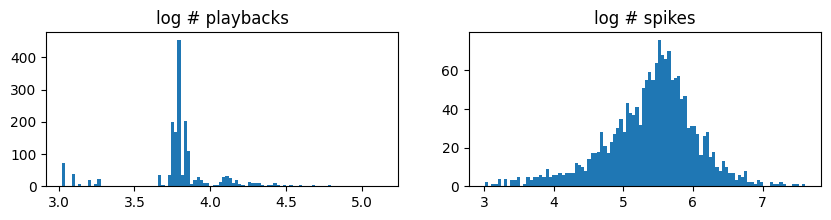

B1597 total # merged units: 1763


unit:   0%|          | 0/1763 [00:00<?, ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   18.6s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   30.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   39.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   46.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   52.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   57.9s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 201 tasks      | elapsed:  

  0%|          | 0/14022988 [00:00<?, ?it/s]

saving to pickle


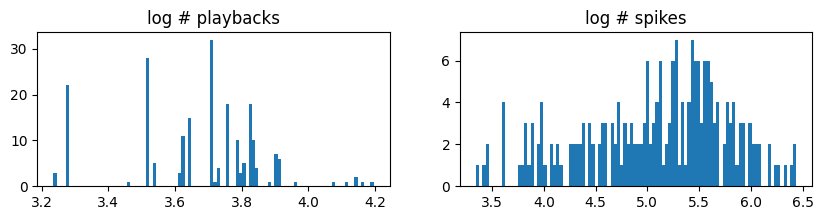

B1188 total # merged units: 214


unit:   0%|          | 0/214 [00:00<?, ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    8.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    9.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   11.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   12.8s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   14.4s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   16.3s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   17.7s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   19.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   21.2s
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:   23.0s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   24.7s
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed:   26.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   27.5s
[Parallel(n_jobs=10)]: Done 214 out of 214 | elapsed:  

  0%|          | 0/1020279 [00:00<?, ?it/s]

saving to pickle


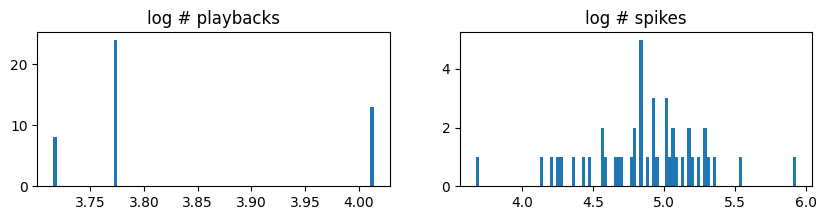

B1595 total # merged units: 45


unit:   0%|          | 0/45 [00:00<?, ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    2.9s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    3.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    3.7s
[Parallel(n_jobs=10)]: Done  31 out of  45 | elapsed:    4.1s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  36 out of  45 | elapsed:    5.0s remaining:    1.2s
[Parallel(n_jobs=10)]: Done  41 out of  45 | elapsed:    5.3s remaining:    0.5s
[Parallel(n_jobs=10)]: Done  45 out of  45 | elapsed:    6.0s finished


  0%|          | 0/212354 [00:00<?, ?it/s]

saving to pickle


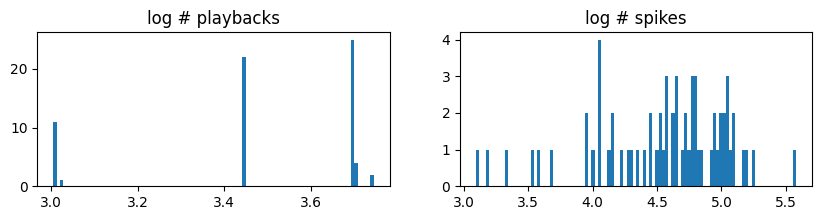

B1426 total # merged units: 65


unit:   0%|          | 0/65 [00:00<?, ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    3.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    3.6s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done  53 out of  65 | elapsed:    4.9s remaining:    1.1s
[Parallel(n_jobs=10)]: Done  60 out of  65 | elapsed:    5.1s remaining:    0.4s
[Parallel(n_jobs=10)]: Done  65 out of  65 | elapsed:    5.2s finished


  0%|          | 0/226777 [00:00<?, ?it/s]

saving to pickle


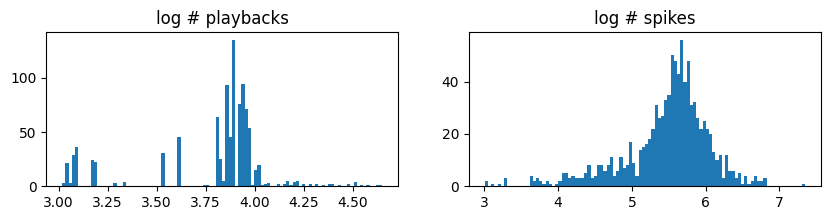

B1432 total # merged units: 968


unit:   0%|          | 0/968 [00:00<?, ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    7.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   12.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   16.7s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   20.0s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   23.1s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   25.9s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   28.6s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   32.0s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   35.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   38.2s
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:   42.4s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   45.5s
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed:   49.6s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   53.9s
[Parallel(n_jobs=10)]: Done 201 tasks      | elapsed:  

  0%|          | 0/7069124 [00:00<?, ?it/s]

saving to pickle


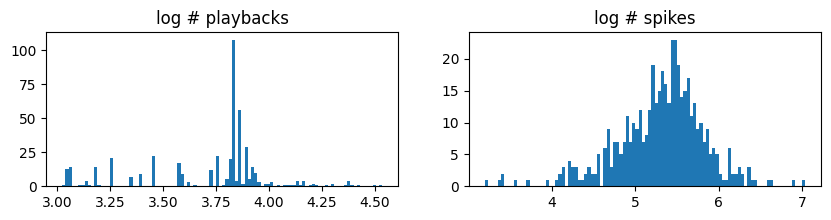

B1170 total # merged units: 467


unit:   0%|          | 0/467 [00:00<?, ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   10.4s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   17.8s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   20.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   21.2s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   24.8s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   26.7s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   28.8s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   30.6s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   33.6s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   35.6s
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:   38.6s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   41.1s
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed:   44.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   46.8s
[Parallel(n_jobs=10)]: Done 201 tasks      | elapsed:  

  0%|          | 0/2901420 [00:00<?, ?it/s]

saving to pickle


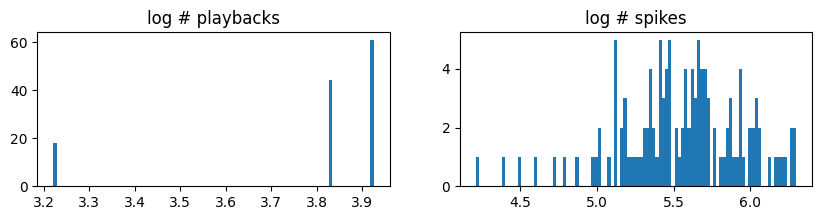

B1244 total # merged units: 123


unit:   0%|          | 0/123 [00:00<?, ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    7.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    9.0s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   10.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   11.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   14.5s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   16.5s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   18.3s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   20.1s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   22.8s
[Parallel(n_jobs=10)]: Done 117 out of 123 | elapsed:   24.3s remaining:    1.2s
[Parallel(n_jobs=10)]: Done 123 out of 123 | elapsed:   24.6s finished


  0%|          | 0/841046 [00:00<?, ?it/s]

saving to pickle


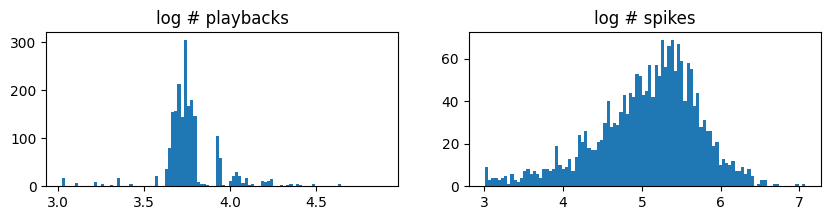

B1593 total # merged units: 2054


unit:   0%|          | 0/2054 [00:00<?, ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   10.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   16.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   21.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   25.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   29.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   33.7s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   38.8s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   43.3s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   47.6s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   51.4s
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:   55.9s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  1.0min
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 201 tasks      | elapsed:  

  0%|          | 0/13320543 [00:00<?, ?it/s]

saving to pickle


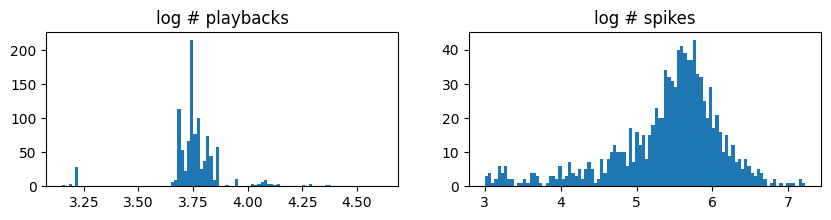

B1248 total # merged units: 1021


unit:   0%|          | 0/1021 [00:00<?, ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   12.7s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   16.7s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   19.8s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   22.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   25.2s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:   27.6s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:   29.7s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:   31.8s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:   34.3s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   36.5s
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:   39.1s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   41.7s
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed:   52.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   54.5s
[Parallel(n_jobs=10)]: Done 201 tasks      | elapsed:  

  0%|          | 0/6172668 [00:00<?, ?it/s]

saving to pickle


In [20]:
for bird, timestamp, sorter in tqdm(birds):
    spikesorting_folder = (DATA_DIR
                / "spikesorting"
                / bird
                / timestamp)
    # get the summary of recordings for the bird
    recording_summary_df = pd.read_pickle(
        DATA_DIR / "spikesorting" / "recording_df" / f"{bird}.pickle.zip"
    )

    # get units that are to be merged
    merged_units = pd.read_pickle(
            DATA_DIR / "spikesorting" / "unit_clusters" / f"{bird}.pickle.zip"
        )
    merged_units = merged_units.sort_values(by='n_playbacks', ascending=False)
    merged_units = merged_units[merged_units.n_playbacks.astype('float')  > min_playbacks]
    
    # subset only units that are categorical
    categorical_merged_units_mask = np.isin(merged_units.cluster_id.values, categorical_units_df[categorical_units_df['bird'] == bird].unit.astype(int).values)
    merged_units = merged_units[categorical_merged_units_mask]
    
    plot = True
    if plot:
        fig, axs = plt.subplots(ncols=2, figsize=(10,2))
        axs[0].hist(np.log10(merged_units.n_playbacks.values.astype('float')+1), bins = 100);
        axs[0].set_title('log # playbacks')
        axs[1].hist(np.log10(merged_units.n_spikes.values.astype('float')+1), bins = 100);
        axs[1].set_title('log # spikes')
        plt.show()
        print('{} total # merged units: {}'.format(bird, len(merged_units)))

    ensure_dir(spikesorting_folder / 'population_statistics' / statistics_timestamp)
    
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=Warning)
        all_unit_spikes = Parallel(n_jobs = 10, verbose=10)(
            delayed(get_n_spikes)(
                unit_to_analyze,
                spikesorting_folder,
                statistics_timestamp,
                bird = bird,
                recompute=True,
                parallel=True,

                        )
            for uniti, unit_to_analyze in tqdm(
                merged_units.iterrows(), desc="unit", total=len(merged_units)
            )
        );
        
    # subset
    all_unit_spikes = [i for i in all_unit_spikes if type(i) == pd.DataFrame]
    
    merged_df = (
        pd.concat(all_unit_spikes, keys=range(1, len(all_unit_spikes) + 1))
        .reset_index(level=1, drop=True)
        .reset_index()
    )
    del all_unit_spikes

    # remove any columns without a trial name
    merged_df = merged_df[np.array([type(i) == str for i in merged_df.trial_id.values])]
    
    merged_df = merged_df.rename(columns={"index": "unit"})

    unique_units = merged_df.unit.unique()
    unique_trials = merged_df.trial_id.unique()
    unique_trial_dict = dict(zip(unique_trials, np.arange(len(unique_trials))))

    ensure_dir(DATA_DIR / 'population_analyses_with_passive2')    
    units_present = np.zeros(len(unique_trials))

    # Create a temporary file
    with tempfile.NamedTemporaryFile(delete=False) as temp_file:
        temp_file_path = temp_file.name
    
    memmap_file_path = DATA_DIR / 'population_analyses_with_passive2' / f"{bird}_spike_array.dat"
    # Create a memmap array
    shape = (len(unique_trials), len(unique_units), len(merged_df.iloc[0].spike_vector))
    spike_array = np.memmap(temp_file_path, dtype=np.float32, mode='w+', shape=shape)
    
    # Populate the memmap array
    for idx, row in tqdm(merged_df.iterrows(), total=len(merged_df)):
        if type(row.trial_id) != str and np.isnan(row.trial_id):
            continue
        spike_array[unique_trial_dict[row.trial_id], row.unit-1, :] = row.spike_vector.astype(np.float32)
        units_present[unique_trial_dict[row.trial_id]] += 1
    # Flush changes to disk
    spike_array.flush()
    shutil.move(temp_file_path, memmap_file_path)

    #ensure_dir(DATA_DIR / 'population_analyses_with_passive')    
    #np.save(DATA_DIR / 'population_analyses_with_passive' / f"{bird}_spike_array.npy", spike_array)
    #del spike_array 
    np.save(DATA_DIR / 'population_analyses_with_passive2' / f"{bird}_units_present.npy", units_present)

    print('saving to pickle')
    merged_df[
          ['unit', 'trial_id', 'cue', 'interp', 'interp_point', 'interp_point_binned']
      ].to_pickle(DATA_DIR / 'population_analyses_with_passive2' / f'{bird}.pickle')

In [21]:
breakme

NameError: name 'breakme' is not defined

In [ ]:
for uniti, unit_to_analyze in tqdm(
                merged_units.iterrows(), desc="unit", total=len(merged_units)
            ):
    
    test = get_n_spikes(
                unit_to_analyze,
                spikesorting_folder,
                statistics_timestamp,
                bird = bird,
                recompute=True,
                parallel=True,

                        )
    break

In [ ]:
test